## Setup

Importing relevant libaries and reading data

In [285]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy import stats
import os

### [IMPORTANT]

This code relies on the csv files being in a folder called ```patch_csvs/``` located in the same directory as this script. Ensure that the folder has 2 kinds of csv files – metrics and patch length

In [289]:
# read all metrics and patch_length files from csv folder
csv_folder = './patch_csvs'
metrics_files = [f for f in os.listdir(csv_folder) if f.startswith('metrics')]
patch_length_files = [f for f in os.listdir(csv_folder) if f.startswith('patch_length')]

## Cleaning and Preparing Metrics Data

The following sections look at raw slice-level data without segregating by case classification (benign versus high-grade). See lower in the code for case-level aggregation

In [291]:
# create df to store patched image metrics data
metrics_df = pd.DataFrame(columns=['slice','num_patches', 'epithelium_coverage'])

# loop through all metrics csv files and add patch num + epithelium coverage values to above df
for f in metrics_files:
    path = os.path.join(csv_folder, f)
    df = pd.read_csv(path)
    slice_name = f.removeprefix("metrics_").removesuffix(".csv")
    metrics_df.loc[len(metrics_df)] = [slice_name, df.iloc[0,1], df.iloc[1,1]] # first val is num_patches, second val is epithelium_coverage

metrics_df.head()

,slice,num_patches,epithelium_coverage
0,case_15_unmatched_10_melan,153.0,92.838823
1,case_12_unmatched_1_melan,80.0,95.423090
2,case_061_match_1_h&e,269.0,92.939825
3,case_27_match_1_melan,61.0,95.203790
4,case_073_match_1_melan,403.0,95.330879


In [293]:
print("Total number of patches =", sum(metrics_df['num_patches']))

Total number of patches = 65372.0


### Significant Data Points for Metrics

In [296]:
# min number of patches
metrics_df.iloc[np.argmin(metrics_df['num_patches']),:]

slice                  case_63_match_6_melan
num_patches                              4.0
epithelium_coverage                99.480752
Name: 542, dtype: object

In [298]:
# important statistics for patch number
print(np.median(metrics_df['num_patches']))
print(np.percentile(metrics_df['num_patches'], 25))
print(np.percentile(metrics_df['num_patches'], 75))
print(stats.mode(metrics_df['num_patches']))

97.0
54.0
155.0
ModeResult(mode=124.0, count=11)


In [300]:
# important statistics for epithelium coverage
print(np.median(metrics_df['epithelium_coverage']))
print(np.percentile(metrics_df['epithelium_coverage'], 25))
print(np.percentile(metrics_df['epithelium_coverage'], 75))

96.49385744859035
94.47847173256974
97.98062387786467


In [302]:
# min epithelium coverage
metrics_df.iloc[np.argmin(metrics_df['epithelium_coverage']),:]

slice                  case_38_match13_h&e
num_patches                           31.0
epithelium_coverage               67.73773
Name: 210, dtype: object

## Metrics Distribution Analysis

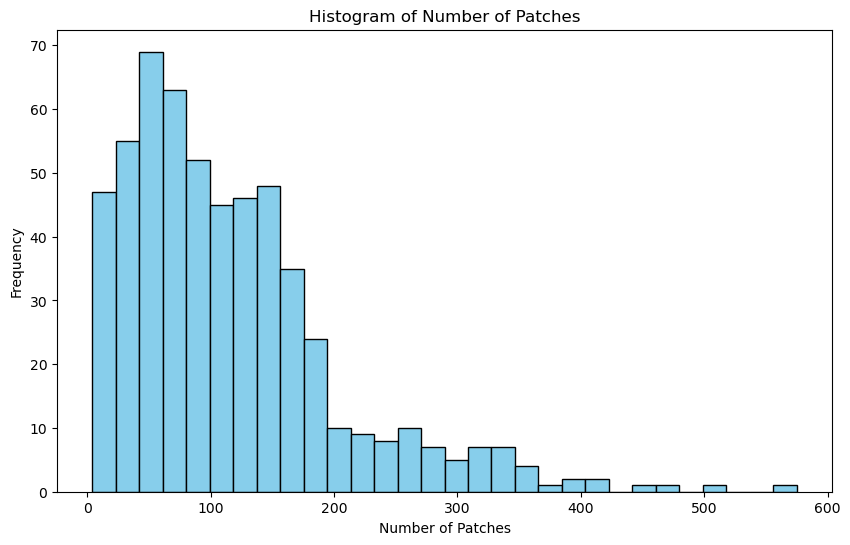

In [305]:
# histogram for number of patches
plt.figure(figsize=(10, 6))
plt.hist(metrics_df['num_patches'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Number of Patches')
plt.xlabel('Number of Patches')
plt.ylabel('Frequency')
plt.show()

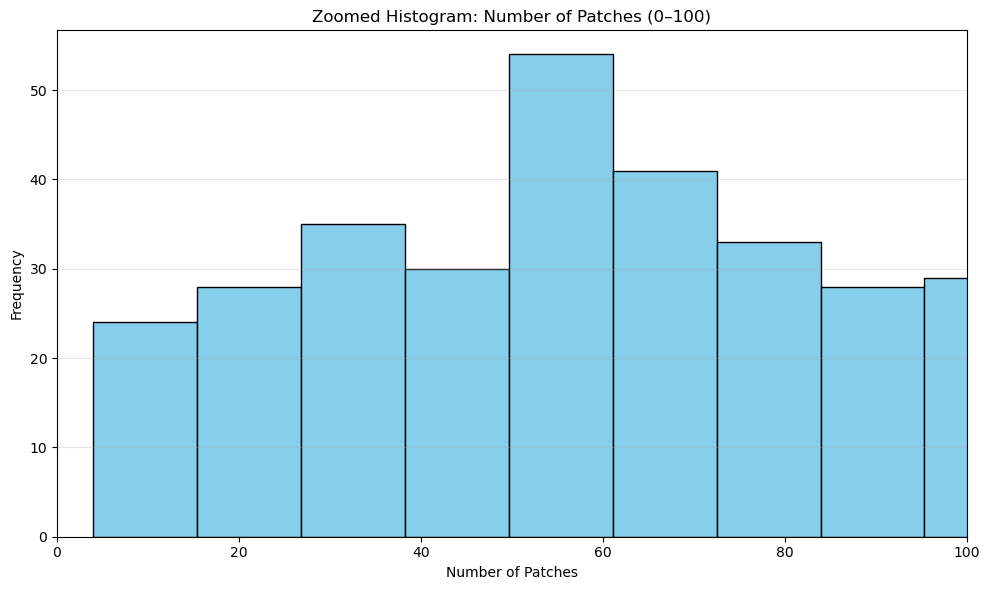

In [307]:
# zooming in
plt.figure(figsize=(10, 6))
plt.hist(metrics_df['num_patches'], bins=50, color='skyblue', edgecolor='black')  # more bins = finer granularity
plt.xlim(0, 100)  # zoom in on 0–100 range
plt.xlabel('Number of Patches')
plt.ylabel('Frequency')
plt.title('Zoomed Histogram: Number of Patches (0–100)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

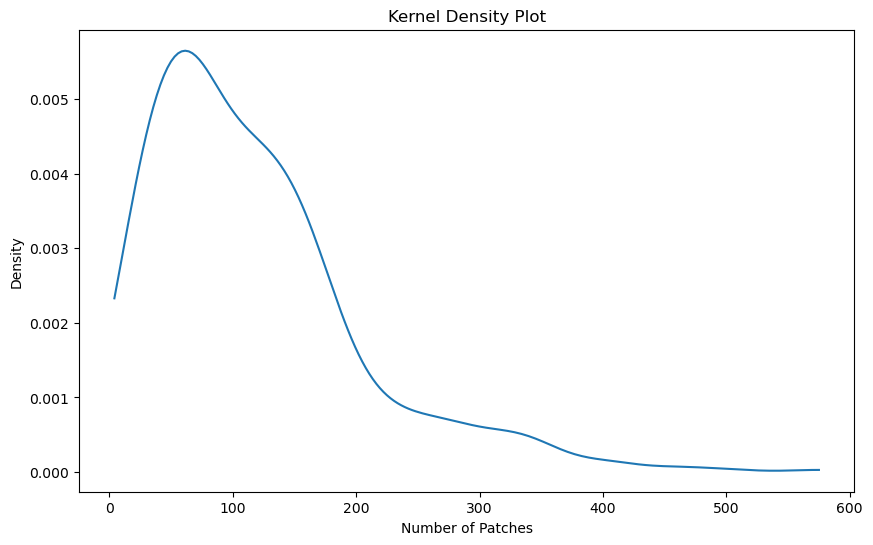

In [309]:
# density plot
density = gaussian_kde(metrics_df['num_patches'])

# Create a range of x values for plotting
x = np.linspace(min(metrics_df['num_patches']), max(metrics_df['num_patches']), 200)

# Plot the KDE
plt.figure(figsize=(10, 6))
plt.plot(x, density(x))
plt.xlabel('Number of Patches')
plt.ylabel('Density')
plt.title('Kernel Density Plot')
plt.show()

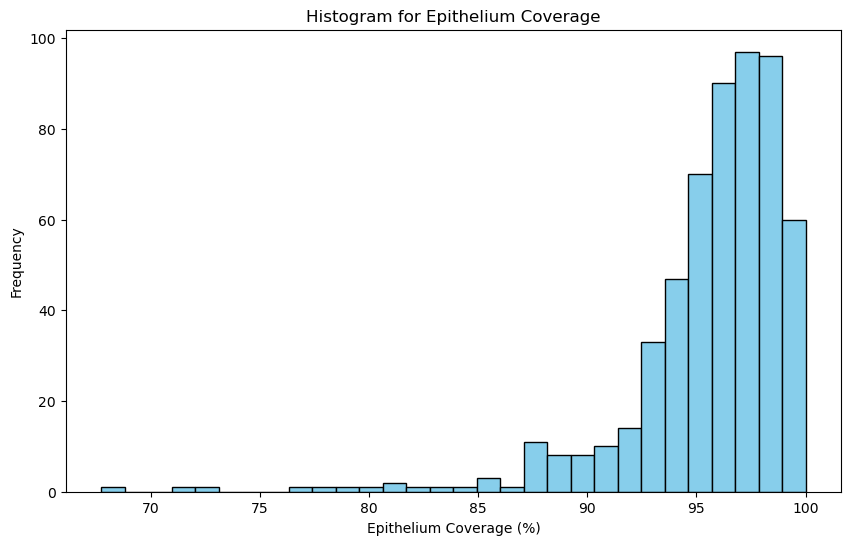

In [311]:
# histogram for epithelium coverage
plt.figure(figsize=(10, 6))
plt.hist(metrics_df['epithelium_coverage'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Epithelium Coverage (%)')
plt.ylabel('Frequency')
plt.title('Histogram for Epithelium Coverage')
plt.show()

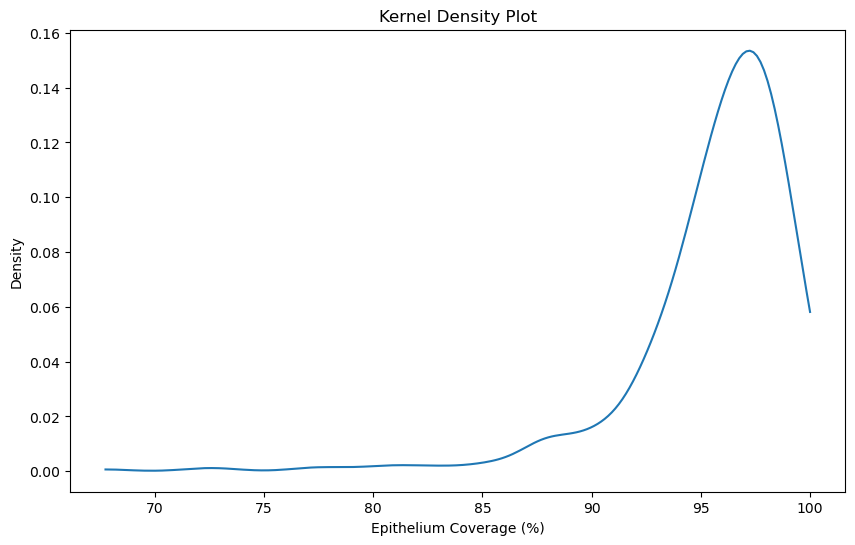

In [313]:
# density plot
density = gaussian_kde(metrics_df['epithelium_coverage'])

# Create a range of x values for plotting
x = np.linspace(min(metrics_df['epithelium_coverage']), max(metrics_df['epithelium_coverage']), 200)

# Plot the KDE
plt.figure(figsize=(10, 6))
plt.plot(x, density(x))
plt.xlabel('Epithelium Coverage (%)')
plt.ylabel('Density')
plt.title('Kernel Density Plot')
plt.show()

## Cleaning and Preparing Patch Length Data

In [315]:
# create df to store patch length data
length_df = pd.DataFrame(columns=['slice','lengths'])

# list to store all lengths
nested_all_lens = []

# loop through all patch length csv files and add lengths to above df as a list
for f in patch_length_files:
    path = os.path.join(csv_folder, f)
    df = pd.read_csv(path)
    lens = df.values.ravel().tolist() # read all length values and create list
    nested_all_lens.append(lens) # this is a nested list
    slice_name = f.removeprefix("patch_length").removesuffix(".csv")
    length_df.loc[len(length_df)] = [slice_name, lens]

all_lens_raw = [item for sublist in nested_all_lens for item in sublist] # create one list with all patch length values
all_lens = [x for x in all_lens if not pd.isna(x)]
length_df.head()

,slice,lengths
0,_case_075_match_1_melan,"[60.0, 624.0, 60.0, 264.0, 56.0, 216.0, 76.0, ..."
1,_case_066_match_3_melan,"[176.0, 52.0, 108.0, 112.0, 88.0, 84.0, 316.0,..."
2,_case_100_match_1_h&e,"[148.0, 180.0, 160.0, 148.0, 116.0, 140.0, 144..."
3,_case_064_match_4_sox10,"[336.0, 96.0, 336.0, nan, 352.0, nan, 276.0, n..."
4,_case_072_match_1_h&e,"[308, 312, 248, 116, 100, 112, 144, 160, 172, ..."


## Patch Length Distribution Analysis

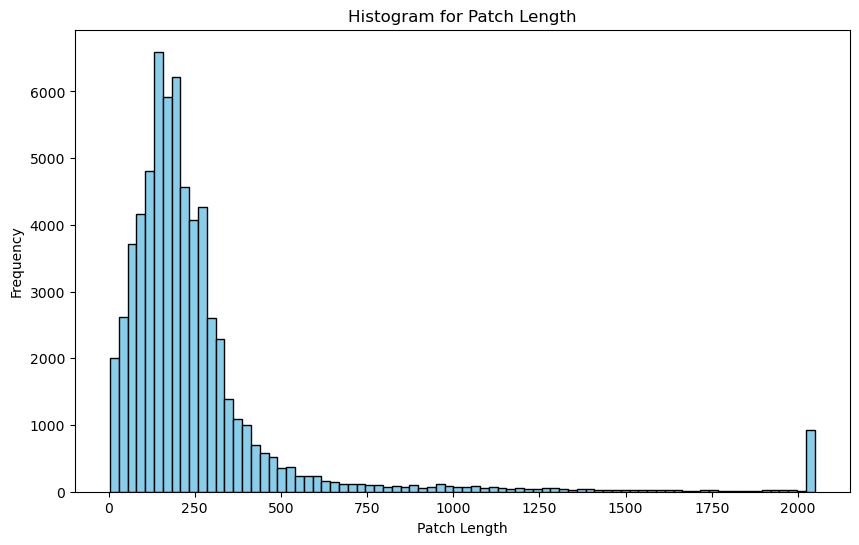

In [317]:
# histogram of patch lengths
plt.figure(figsize=(10, 6))
plt.hist(all_lens, bins=80, color='skyblue',edgecolor='black')
plt.xlabel('Patch Length')
plt.ylabel('Frequency')
plt.title('Histogram for Patch Length')
plt.show()

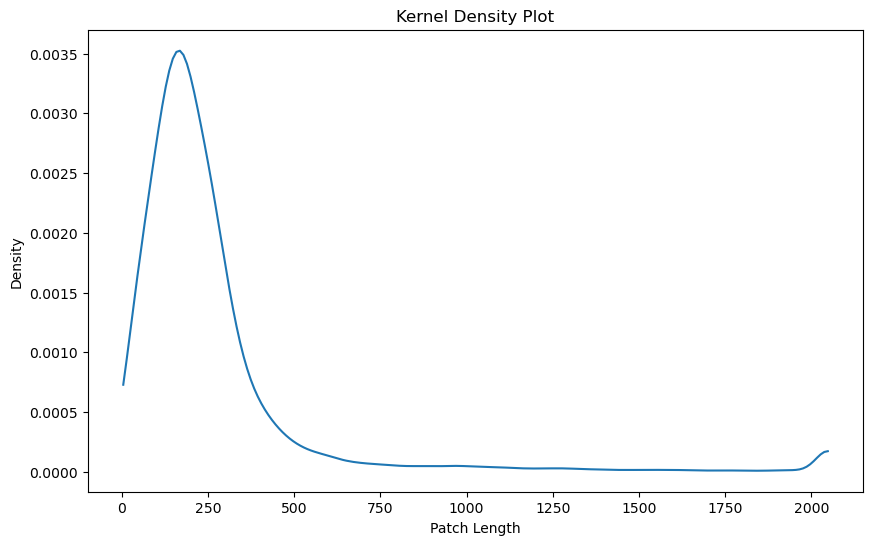

In [319]:
# density plot
density = gaussian_kde(all_lens)

# Create a range of x values for plotting
x = np.linspace(min(all_lens), max(all_lens), 200)

# Plot the KDE
plt.figure(figsize=(10, 6))
plt.plot(x, density(x))
plt.xlabel('Patch Length')
plt.ylabel('Density')
plt.title('Kernel Density Plot')
plt.show()

In [321]:
# important statistics
print(np.median(all_lens))
print(np.percentile(all_lens, 25))
print(np.percentile(all_lens, 75))
print(stats.mode(all_lens))

192.0
124.0
280.0
ModeResult(mode=172.0, count=1093)


## Aggregating into Case Level Data

In [332]:
# extract case number
metrics_df['case'] = metrics_df['slice'].str.extract(r'case_(\d+)', expand=False)
metrics_df['case'] = metrics_df['case'].astype(int)

# create case aggregated dataframe
agg_df = metrics_df.groupby('case').agg({
    'num_patches': 'sum',  # summing number of patches
    'epithelium_coverage': 'mean'  # average epithelium coverage across slices
}).reset_index()

agg_df.head()

,case,num_patches,epithelium_coverage
0,1,452.0,93.897557
1,2,673.0,94.076937
2,3,862.0,96.870209
3,4,941.0,93.507114
4,5,508.0,97.414672
